### 문제

- 1layer NN (Perceptron)
- SGD optim을 이용한 손글씨 분류기

In [ ]:
import torch                                
import torchvision.datasets as data           # torchvision을 이용해 dataset을 불러옴
import torchvision.transforms as transforms
import random

In [ ]:
# GPU 사용

device = 'cuda' if torch.cuda.is_available() else 'cpu' # GPU가 내 시스템에 없다면 CPU를 사용하겠다.

 # 실험 반복시마다 동일한 값을 생성하기 위해 
 # 3개의 랜덤 seed고정

random.seed(777)                   
torch.manual_seed(777)              
if device == 'cuda':
  torch.cuda.manual_seed_all(777)

In [ ]:

# 학습 파라미터 설정
learning_rate = 0.001
training_epochs = 15
batch_size = 100


- root: 저장경로
- 학습/테스트 데이터 선택: True 학습데이터
- transform:
- download: 


In [ ]:
mnist_train = data.MNIST(root='MNIST_data/',
                         train=True,                          # train데이터를 받는지
                         transform=transforms.ToTensor(),     # tensor로 데이터를 받겠다.
                         download=True)                       # 데이터셋이 없다면 down받아달라는 의미

# test데이터를 받기 위해서는 train=False
mnist_test = data.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

In [ ]:

data_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)
# data loader가 batch size에 맞게 데이터를 잘라준다.
# 데이터를 섞어서 학습
# drop_last: batch size설정 후 남는 데이터를 버릴지 말지 여부

![대체 텍스트](https://user-images.githubusercontent.com/11758940/83336289-229ec200-a2ed-11ea-9fb8-88a51198e475.png)

In [ ]:
# layer가 하나이기때문에 입력받아서 출력을 그대로 맞춰준다.

linear = torch.nn.Linear(784,10,bias=True)

# 출력 10개. one hot encoding

[메뉴얼] https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.normal_

In [ ]:
# 신경망 초기화 
# init.normal_: 랜덤 initialize 사용 

torch.nn.init.normal_(linear.weight)

Parameter containing:
tensor([[-0.1953, -0.4404,  0.0139,  ...,  0.7510,  1.5190,  0.9637],
        [ 0.4146, -1.0660, -0.9969,  ..., -0.3259, -0.2695, -1.3316],
        [ 0.2600, -1.1821,  0.0065,  ...,  1.0648, -1.2251,  0.9841],
        ...,
        [ 0.0279, -1.7242, -1.1723,  ...,  1.3651, -0.0689, -0.7931],
        [ 0.0952,  0.1939,  0.1636,  ..., -1.0489,  0.6224, -1.7181],
        [ 2.6504,  0.6297, -1.6571,  ..., -0.0781, -1.1398, -0.8711]],
       requires_grad=True)

In [ ]:
model = torch.nn.Sequential(linear).to(device)  

# to(device) = to GPU   'cuda' GPU메모리에 저장했다는 의미

[메뉴얼] https://pytorch.org/docs/stable/nn.html#crossentropyloss

In [ ]:
loss = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) # 0.49

In [ ]:

total_batch = len(data_loader)        # mini batch의 크기. 갯수. = 전체데이터/batchsize
for epoch in range(training_epochs):  # 전체 데이터 60000개의 학습을 15번 반복
    avg_cost = 0

    for X, Y in data_loader:          #전체 데이터 60000을 1번 봄. 

        # (100, 1, 28, 28) 크기의 텐서를 (1000, 784) 크기의 텐서로 변형
        # (100은 batch size, )
        X = X.view(-1, 28 * 28).to(device)          # view = reshape: 데이터 가공


        # one-hot encoding되어 있지 않음
        Y = Y.to(device)
        #%debug

        # 그래디언트 초기화
        optimizer.zero_grad()
        # Forward 계산
        hypothesis = model(X)         #예측된 결과
        # Error 계산
        cost = loss(hypothesis, Y)    # 실제 값과의 오차
        # Backparopagation
        cost.backward()
        # 가중치 갱신
        optimizer.step()

        # 평균 Error 계산
        avg_cost += cost / total_batch

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

print('Learning finished')

Epoch: 0001 cost = 14.411854744
Epoch: 0002 cost = 12.304099083
Epoch: 0003 cost = 10.895847321
Epoch: 0004 cost = 9.731021881
Epoch: 0005 cost = 8.741781235
Epoch: 0006 cost = 7.916104794
Epoch: 0007 cost = 7.235820770
Epoch: 0008 cost = 6.667829990
Epoch: 0009 cost = 6.180720806
Epoch: 0010 cost = 5.753791332
Epoch: 0011 cost = 5.375432014
Epoch: 0012 cost = 5.038475037
Epoch: 0013 cost = 4.737658978
Epoch: 0014 cost = 4.468713284
Epoch: 0015 cost = 4.227884769
Learning finished


## 성능확인

In [ ]:
# Test the model using test sets

with torch.no_grad():
    # flaot() : GPU=>CPU로 데이터 내리기
    X_test = mnist_test.test_data.view(-1, 28 * 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = model(X_test)    #one hot encoding 상태이므로, 아래에서 argmax를 수행하여 라벨값을 구한다.
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())


Accuracy: 0.4213999807834625


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [ ]:
# 랜덤 테스트
r = random.randint(0, len(mnist_test) - 1)
X_single_data = mnist_test.test_data[r:r + 1].view(-1, 28 * 28).float().to(device)
Y_single_data = mnist_test.test_labels[r:r + 1].to(device)

print('Label: ', Y_single_data.item())
single_prediction = model(X_single_data)
print('Prediction: ', torch.argmax(single_prediction, 1).item())

# 8을 7로 잘못 예측하였다.

Label:  8
Prediction:  7


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


tensor([8], device='cuda:0')


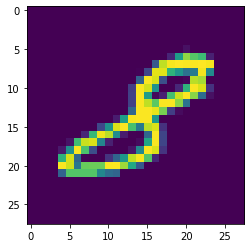

In [ ]:
# 숫자 눈으로 뿌려보기
import matplotlib.pyplot as plt
plt.imshow(X_single_data.reshape(28,28).cpu())
print(Y_single_data)